**Section 1: Problem Definition and Dataset Analysis**

The goal of this analysis is to predict customer churn for a telecom company. The dataset contains customer information and includes features like tenure, monthly charges, and total charges, along with a target variable indicating whether a customer has churned.

*   Class Distribution: A countplot is generated to visualize the distribution of churn (i.e., whether the customer has left or stayed).
*   Missing Values: Missing values are identified using .isnull().sum(), and any missing data is handled (e.g., replacing missing "TotalCharges" values with the median).



**1.1 Load Libraries**

Essential libraries like Pandas, NumPy, Seaborn, and Matplotlib are loaded for data manipulation, visualization, and model building. Scikit-learn is used for machine learning tasks, including model evaluation and feature scaling.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

**Intrepretation:** Set up the environment by importing all the necessary tools for data manipulation, visualization, model training, evaluation, and interpretation. This is the standard first step in any machine learning project.

**1.2 Load the dataset**

The dataset is loaded from a CSV file.

In [2]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

**Interpretation:** Load it into a pandas DataFrame called df.

**1.3 Dataset Information**

*   **Dataset Overview:** The dataset is loaded from a CSV file. The **.shape** provides the total number of rows and columns in the dataset whereas **head()** displays the first five rows of the dataset by default.
The **.info()** and **.describe()** methods provide insights into the dataset’s structure and summary statistics.
*   **Class Distribution:** A countplot is generated to visualize the distribution of churn (i.e., whether the customer has left or stayed).
*   **Missing Values:** Missing values are identified using **.isnull().sum()**, and any missing data is handled (e.g., replacing missing "TotalCharges" values with the median)



In [3]:
# Total number of rows and columns
df.shape

(7043, 21)

In [4]:
# Display the first five rows of the dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


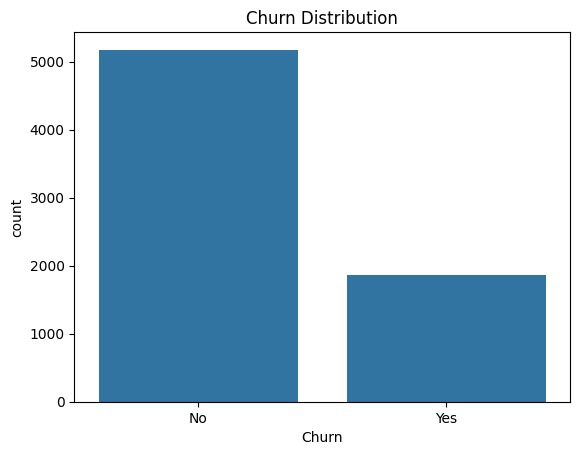

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
# Display dataset info
print(df.info())
print(df.describe())

# Checking class distribution
sns.countplot(x=df['Churn'])
plt.title("Churn Distribution")
plt.show()

# Checking missing values
print(df.isnull().sum())

**Interpretation:** Perform crucial initial steps in data exploration and cleaning: understanding the structure and content of the data, visualizing the distribution of the target variable, and checking for missing values. The bar chart shows a class imbalance, with significantly more customers not churning ("No") than churning ("Yes"). This imbalance is a critical consideration for model development, potentially biasing models towards the majority class and hindering accurate churn prediction.

In [6]:
# Ensuring that the Churn column doesn't contain any missing values
df['Churn'].isnull().sum()

0

**Section 2: Data Preprocessing and Feature Engineering**

Preprocessing includes data cleaning and feature transformation steps to make the dataset ready for machine learning algorithms.


**2.1 Handling Missing Values and Encoding**

The column **TotalCharges** is processed to handle non-numeric values (converted to NaN). Missing values are replaced with the median value of that column.

In [7]:
# Replace empty strings in 'TotalCharges' with NaN and convert to float
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Fill missing values with median
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

**2.2 Feature Encoding**

 The categorical variable **Churn** is label-encoded (1 for churn, 0 for no churn). One-hot encoding is applied to other categorical variables to convert them into numerical values.

In [8]:
# Convert categorical variables
# Check if 'customerID' column exists before dropping
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])  # Yes = 1, No = 0

In [9]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True)

In [10]:
df.head(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [11]:
# printing the unique values in all the columns

numerical_features_list = ["tenure","MonthlyCharges","TotalCharges"]

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print('-'*50)

SeniorCitizen [0 1]
--------------------------------------------------
Churn [0 1]
--------------------------------------------------
gender_Male [0 1]
--------------------------------------------------
Partner_Yes [1 0]
--------------------------------------------------
Dependents_Yes [0 1]
--------------------------------------------------
PhoneService_Yes [0 1]
--------------------------------------------------
MultipleLines_No phone service [1 0]
--------------------------------------------------
MultipleLines_Yes [0 1]
--------------------------------------------------
InternetService_Fiber optic [0 1]
--------------------------------------------------
InternetService_No [0 1]
--------------------------------------------------
OnlineSecurity_No internet service [0 1]
--------------------------------------------------
OnlineSecurity_Yes [0 1]
--------------------------------------------------
OnlineBackup_No internet service [0 1]
--------------------------------------------------


In [12]:
df.isnull().sum()

,0
SeniorCitizen,0
tenure,0
MonthlyCharges,0
TotalCharges,0
Churn,0
gender_Male,0
Partner_Yes,0
Dependents_Yes,0
PhoneService_Yes,0
MultipleLines_No phone service,0


**2.3 Feature Scaling**

Numerical features such as **tenure**, **MonthlyCharges**, and **TotalCharges** are scaled using **StandardScaler** to standardize the values.

In [13]:
# Feature scaling for numerical columns
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Splitting data
X = df.drop(columns=['Churn'])
y = df['Churn']

**2.4 Train-Test Split**

The dataset is split into training and testing sets using **train_test_split**, with a stratified split ensuring balanced class distribution in both sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**2.5 Further EDA (After Handling Missing Values)**

In [15]:
df.shape

(7043, 31)

In [16]:
df.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [16]:
df.head(2)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994242,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,0.066327,-0.259629,-0.173244,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


**2.6 Histogram with Mean and Median Lines**

**Key Steps:**
*   **Function Definition:** The **plot_histogram** function visualizes the distribution of a specified column in the dataset using a histogram. It also overlays vertical lines to represent the mean and median of the data.
*   **Data Visualization:** The histogram is created using Seaborn's **sns.histplot()**, displaying the distribution of the column's values along with a kernel density estimate (KDE) for a smoother curve.
*   **Mean and Median Lines:** The function calculates the mean and median of the specified column and adds vertical lines to the plot: The **mean** is represented by a red dashed line.
The **median** is represented by a green solid line.
*   **Legend**: A **legend** is included to distinguish between the mean and median lines, enhancing interpretability.
* **Purpose**: The histogram provides a clear view of the data's distribution, while the mean and median lines help to compare the central tendencies, aiding in a deeper understanding of the data's characteristics.

In [17]:
def plot_histogram(df, column_name):
  plt.figure(figsize=(5,3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")
  # Calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  #add vertical lines for mean and median
  plt.axvline(col_mean, color='red', linestyle='dashed', label='Mean')
  plt.axvline(col_median, color='green', linestyle='solid', label='Median')

  plt.legend()

  plt.show()

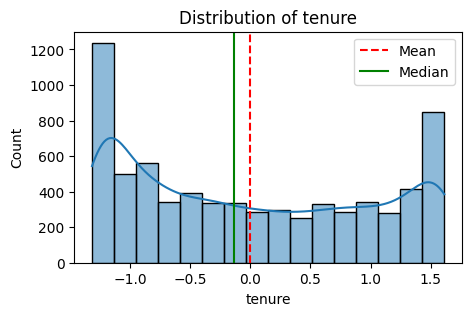

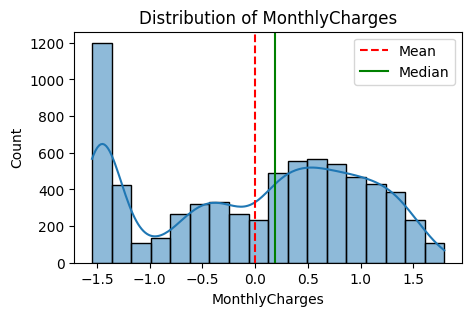

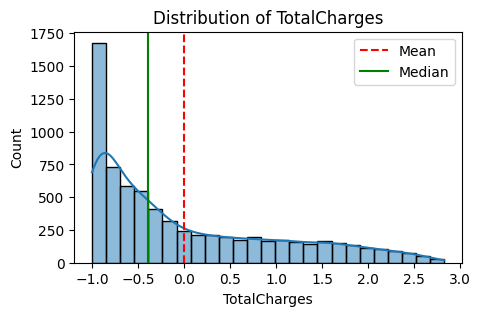

In [18]:
# Plots histograms for the columns 'tenure', 'MonthlyCharges', and 'TotalCharges' in the dataset, showing the distribution of each feature.
plot_histogram(df, 'tenure')
plot_histogram(df, 'MonthlyCharges')
plot_histogram(df, 'TotalCharges')

**Interpretation:** The charts show how long customers stay (tenure), how much they pay monthly, and their total charges.  Tenure has two peaks, like there are lots of new customers and lots of long-time customers.  Both monthly and total charges are uneven, with most customers paying less and a few paying much more.  The average charge is higher than the middle charge, showing that the higher-paying customers skew the average. These charge differences could be because of longer service or pricier plans.  These patterns suggest different types of customers and that we might need to adjust the data before using it in our models.


**2.7 Box Plot Visualizations**

**Key Steps:**
*   **Box Plot Functionality:** The **plot_boxplot** function generates a box plot for the specified column in the dataset, displaying the distribution of values along with potential outliers.
*   **Purpose**: Box plots are used to visualize the spread of the data, identify outliers, and determine the central 50% range of values, giving an overview of the feature's distribution.


In [19]:
def plot_boxplot(df, column_name):

  plt.figure(figsize=(5,3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Box Plot of {column_name}")
  plt.ylabel(column_name)
  plt.show()

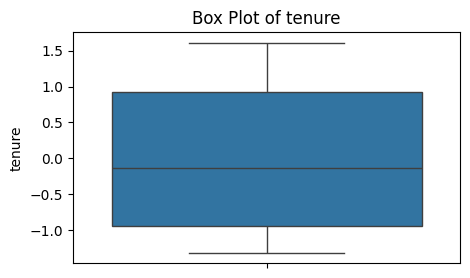

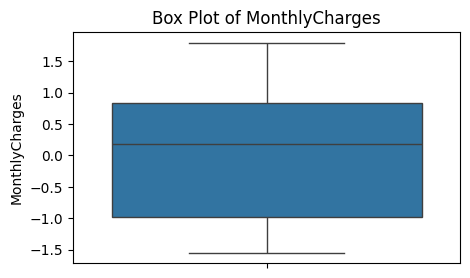

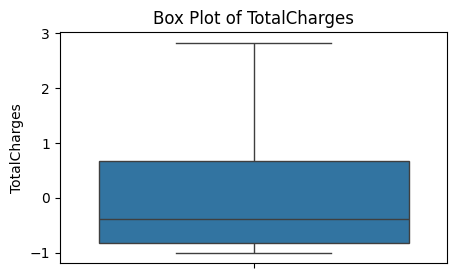

In [20]:
# Box plots for the columns 'tenure', 'MonthlyCharges', and 'TotalCharges' in the dataset, created to examine their distributions and detect any potential outliners.
plot_boxplot(df, 'tenure')
plot_boxplot(df, 'MonthlyCharges')
plot_boxplot(df, 'TotalCharges')

**Interpretation:** The box plots show how long customers stay, and how much they pay monthly and in total.  Most customers stay for a medium amount of time, with a few staying much longer or shorter.  Monthly and total payments vary a lot; while most people pay a moderate amount, some pay much more.  There are a few customers with very high monthly and total charges, which might be unusual.


**2.8 Correlation Matrix Heatmap**

**Key Steps:**
*   **Correlation Analysis:** A heatmap of the correlation matrix is generated for the numerical features **'tenure'**, **'MonthlyCharges'**, and **'TotalCharges'**.
* **Visualization**: Allows for a quick understanding of the relationships between those variables, highlighting any strong correlations or lack thereof.
* **Color intensity and numerical annotations**: Identifies potential multicollinearlity issues or dependencies that could influence model selection and performance.

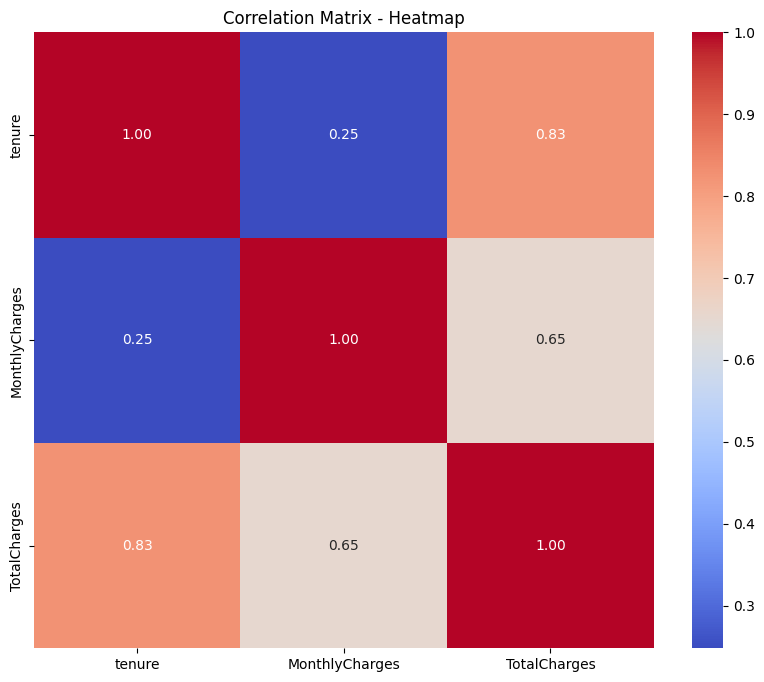

In [21]:
# correlation matrix - heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix - Heatmap")
plt.show()

**Interpretation:** The heatmap visualizes the correlations between tenure, monthly charges, and total charges.  Tenure and total charges exhibit a strong positive correlation (0.83), indicating that customers with longer tenures tend to have higher total charges.  Monthly charges show a moderate positive correlation with total charges (0.65) and a weak positive correlation with tenure (0.25), suggesting that higher monthly charges contribute to higher total charges and that there's a slight tendency for long-term customers to have higher monthly charges.  These positive correlations are logical, as longer tenures and higher monthly payments naturally lead to higher total charges.  The strongest relationship, between tenure and total charges, suggests that customer loyalty (tenure) is a significant driver of overall revenue (total charges).


**Section 3: Model Development and Evaluation**

This section trains and evaluates multiple classification models to predict customer churn. Various models are compared using cross-validation to assess their performance.


**3.1 Multiple Models**

*   **Model Definitions:** Several machine learning models are defined, including Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and more.
*   **Cross-Validation:** Each model is evaluated using 5-fold cross-validation (**StratifiedKFold**), ensuring that the training data is partitioned into equal class proportions. The mean cross-validation accuracy is calculated for each model.



In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "AdaBoost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB()
}

# Train and Evaluate Models
results = {}

**3.2 Training models and evaluating performance**

Each model is trained on the entire training set, and its performance is evaluated on the test set using accuracy scores. The results are stored in a dictionary and displayed as a DataFrame.

In [23]:
for name, model in models.items():
    # Perform 5-Fold Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")

    # Train on entire training set
    model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {"CV Mean Accuracy": np.mean(scores), "Test Accuracy": accuracy}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                        CV Mean Accuracy  Test Accuracy
Logistic Regression             0.802806       0.804826
Ridge Classifier                0.801741       0.794890
Decision Tree                   0.729504       0.739532
Random Forest                   0.787543       0.786373
AdaBoost                        0.800144       0.805536
Extra Trees                     0.773520       0.777147
Support Vector Machine          0.804226       0.794890
K-Nearest Neighbors             0.767306       0.762952
Gradient Boosting               0.802274       0.799148
Naive Bayes                     0.665957       0.655784


**Interpretation:** The code trains and evaluates ten different machine learning models using 5-fold cross-validation and tests their accuracy on a held-out test set. The output table shows the cross-validation accuracy and test accuracy for each model.  Random Forest, Logistic Regression, AdaBoost, and Gradient Boosting achieve the highest test accuracies, suggesting they are the best performers among the tested models for predicting customer churn.


**3.3 Model Comparison**

A barplot compares the models based on their test accuracy, helping identify the best-performing model.

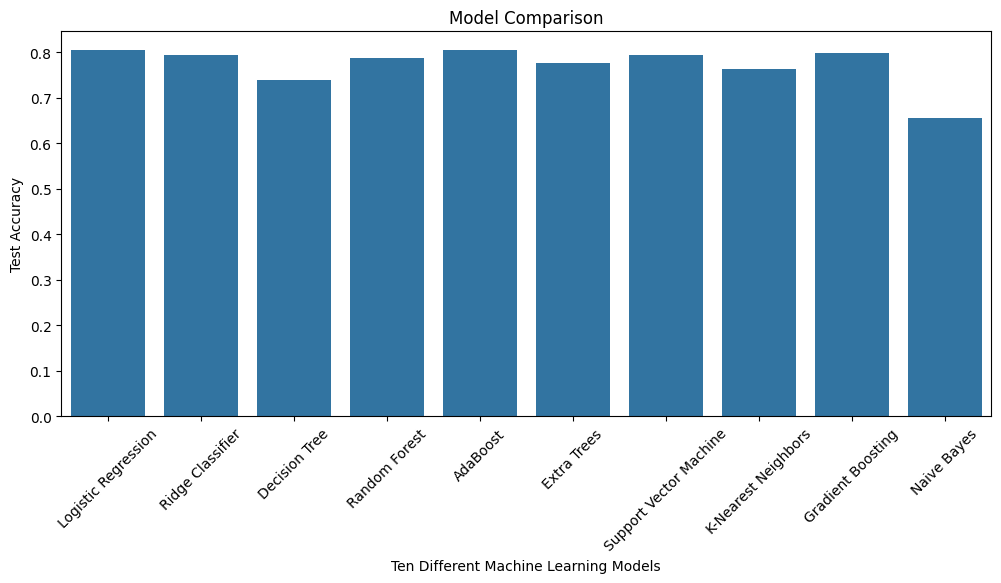

In [24]:
# Plot model comparison
plt.figure(figsize=(12, 5))
sns.barplot(x=results_df.index, y=results_df["Test Accuracy"])
plt.xticks(rotation=45)
plt.xlabel("Ten Different Machine Learning Models")
plt.ylabel("Test Accuracy")
plt.title("Model Comparison")
plt.show()

**Interpretation:** The model comparison bar chart visualizes the test accuracy of ten different machine learning models, revealing that Logistic Regression and AdaBoost achieve the highest performance, closely followed by Random Forest, Gradient Boosting and Support Vector Machine. Ridge Classifier, and Extra Trees demonstrate moderate performance, while Decision Tree and K-Nearest Neighbors exhibit lower accuracy.  Naive Bayes performs the poorest among all models.  This visualization suggests that Logistic Regression and AdaBoost are promising candidates for churn prediction, but further evaluation with additional metrics, k-fold cross-validation and hyperparameter tuning are necessary for final model selection.


**3.4 Stratified K-Fold Cross-Validation**

The models are also evaluated using the Area Under the Receiver Operating Characteristic Curve (AUC-ROC) score, which helps assess the model’s ability to distinguish between the two classes (churn vs. no churn).

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    auc_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        auc_scores.append(roc_auc_score(y_val, y_val_pred))
    print(f"{name} - Average AUC-ROC: {np.mean(auc_scores):.4f}")

Logistic Regression - Average AUC-ROC: 0.7199
Ridge Classifier - Average AUC-ROC: 0.7123
Decision Tree - Average AUC-ROC: 0.6583
Random Forest - Average AUC-ROC: 0.6848
AdaBoost - Average AUC-ROC: 0.7027
Extra Trees - Average AUC-ROC: 0.6752
Support Vector Machine - Average AUC-ROC: 0.7046
K-Nearest Neighbors - Average AUC-ROC: 0.6919
Gradient Boosting - Average AUC-ROC: 0.7120
Naive Bayes - Average AUC-ROC: 0.7333


**Interpretation:** While Naive Bayes had the worst overall accuracy, it surprisingly had the best performance at ranking customers by their churn risk (highest AUC-ROC score).  Other models, like Logistic Regression, Random Forest and Gradient Boosting, had decent ranking abilities too, but not as good as Naive Bayes.  This difference between accuracy and ranking ability shows why it's important to use different metrics – a model can be good at one thing but not another.  Essentially, Naive Bayes might be good at saying who's most likely to churn, even if it's not perfect at saying exactly who will churn.

In [28]:
# To check which model was chosen with its best hyperparameters:
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

NameError: name 'grid_search' is not defined

**3.5 Hyperparameter Tuning**

Hyperparameter tuning is performed to improve model performance by finding the optimal parameters for the Random Forest model.

**Key Steps:**
*   **GridSearchCV:** A grid search is performed to find the best combination of hyperparameters (**n_estimators**, **max_depth**, **min_samples_split**) for the Random Forest model using cross-validation and ROC-AUC scoring.
*   **Best Parameters:** The best set of hyperparameters is identified and displayed.



In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
# Store the best model in the models dictionary
best_model = grid_search.best_estimator_
models['best_model'] = best_model

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=   1.8s
[CV] END max_depth=10, min_samples_split=2, n_e

**Interpretation:** The code searches for the best settings for a Random Forest model by trying out different numbers of trees, tree depths, and minimum split sizes. It uses a method called cross-validation to test each combination and the AUC-ROC score to judge how well it performs. The output shows how long each test took and then reveals the winning combination: 300 trees, a depth of 10, and a minimum split size of 10. This best version of the model is saved for future use.

In [40]:
# Final Model Evaluation
y_pred_final = best_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final))

Final Model Accuracy: 0.8041163946061036
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



**Interpretation:** The model correctly predicted customer churn status about 80.5% of the time overall. However, it's much better at predicting who won't churn than who will.  It's quite accurate at identifying and classifying customers who stay, but it struggles to correctly identify those who leave.  This is probably because there are fewer examples of churn in the data, making it harder for the model to learn those patterns.

**3.6 Unsupervised Learning (K-Means Clustering) and Customer Segmentation**

An unsupervised learning model (K-Means) is applied to identify patterns in the customer data that may correlate with customer churn.

**Key Steps:**
*   **Clustering:** **KMeans** assigns customers to clusters based on features (e.g., tenure, MonthlyCharges).
* **Elbow Method:** Determines the optimal number of clusters by plotting WCSS.
* **Analysis:** Mean values of features per cluster reveal customer segment characteristics.
* **Visualization**: A scatter plot is created using tenure and MonthlyCharges with different cluster labels. The plot shows how the customers are segmented into distinct groups, with each cluster having its own color. This helps in identifying patterns within customer data, like those who have longer tenures but higher monthly charges.





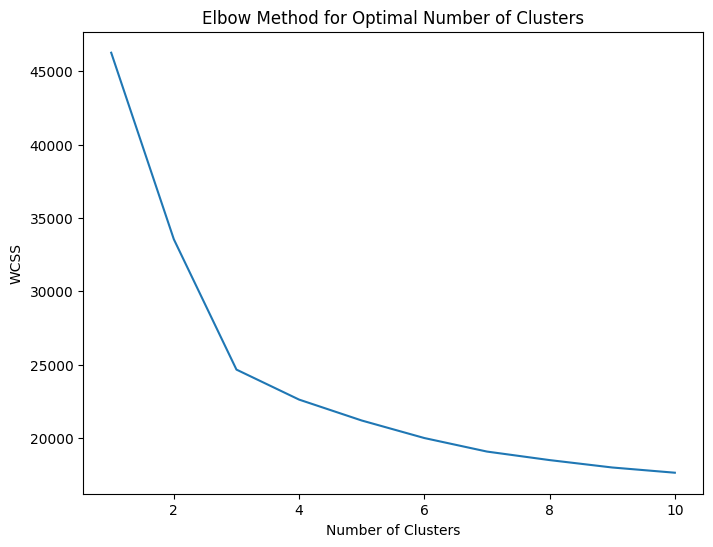

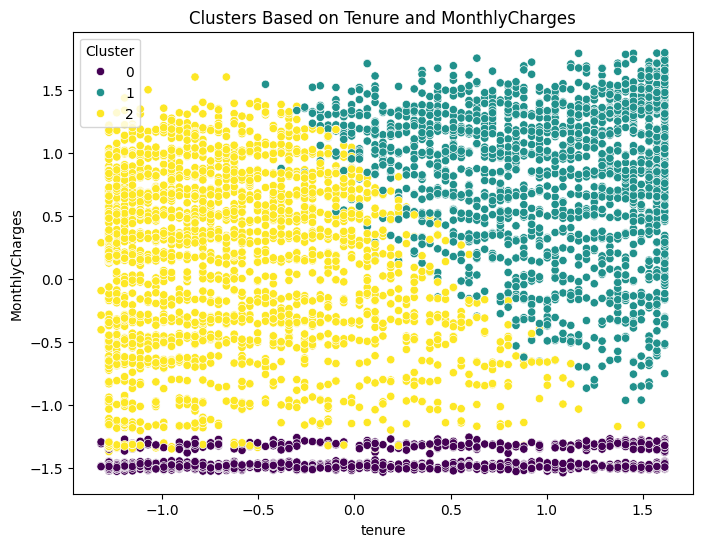

         SeniorCitizen    tenure  MonthlyCharges  TotalCharges  gender_Male  \
Cluster                                                                       
0             0.034596 -0.087598       -1.450646     -0.715282     0.514827   
1             0.208602  1.033458        0.821317      1.265855     0.494624   
2             0.191406 -0.699120        0.103493     -0.561672     0.503125   

         Partner_Yes  Dependents_Yes  PhoneService_Yes  \
Cluster                                                  
0           0.486820        0.423394          1.000000   
1           0.685484        0.343011          0.925269   
2           0.337109        0.205859          0.835938   

         MultipleLines_No phone service  MultipleLines_Yes  ...  \
Cluster                                                     ...   
0                              0.000000           0.229819  ...   
1                              0.074731           0.695699  ...   
2                              0.164062      

In [42]:
from sklearn.cluster import KMeans

# Elbow Method to determine optimal number of clusters
def plot_elbow_method(X):
    wcss = []  # Within-cluster sum of squares
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

# Apply the elbow method
plot_elbow_method(X_train)

# Based on the elbow method, assume we choose 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_train)

# Add the cluster labels to the training data
X_train['Cluster'] = y_kmeans

# Visualizing the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['tenure'], y=X_train['MonthlyCharges'], hue=X_train['Cluster'], palette='viridis')
plt.title('Clusters Based on Tenure and MonthlyCharges')
plt.show()

# Analyzing customer segments based on cluster information
X_train['Cluster'] = y_kmeans
print(X_train.groupby('Cluster').mean())


**Interpretation:**

1.   **Figure 1, the Elbow Method plot,** shows how the "Within-Cluster Sum of Squares" (WCSS) changes as the number of clusters increases.  The sharp bend or "elbow" in the line suggests that 3 clusters is a good balance – adding more clusters doesn't decrease the WCSS as much, indicating diminishing returns.
2. **Figure 2, the scatter plot**, visualizes the three clusters based on customer tenure and monthly charges. Each dot represents a customer, colored according to their cluster.  The plot shows how customers with similar tenure and monthly charges are grouped together.  We can see three distinct groups emerge, allowing for a visual understanding of the customer segmentation.
3. The **Customer Segmentation** allows for targeted analysis and understanding of different customer profiles.



**3.7 Random Forest with SMOTE**
In this section, a Random Forest model is developed and evaluated with an emphasis on handling class imbalance using **SMOTE (Synthetic Minority Over-sampling Technique)** and optimizing for recall. The model’s performance is assessed using **ROC Curve** and **Confusion Matrix**.

**Key Steps:**
* **Handling Class Imbalance with SMOTE:** **SMOTE** is applied to generate synthetic samples for the minority class, addressing the class imbalance in the dataset. This helps the model better predict the minority class without overfitting.
*   **Random Forest Model with Class Weighting:** A Random Forest classifier is trained using class weights (**"balanced"**) to further mitigate class imbalance and give more importance to the minority class during model training.
*   **Data Normalization:** **StandardScaler** is used to normalize both the training and test data to ensure consistent input ranges for the model.
*  ** Threshold Tuning for Recall Optimization:** The decision threshold is lowered to 0.4 to prioritize recall over precision. This tuning increases the number of positive class predictions, boosting recall but potentially lowering precision.
*   **Evaluation with ROC Curve:** The **ROC curve** is plotted to visualize the trade-off between the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** at different threshold values.
*   **Confusion Matrix:** A **Confusion Matrix** is used to evaluate the performance of the model by showing the number of true positives, false positives, true negatives, and false negatives.


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.75      0.81      1035
           1       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409



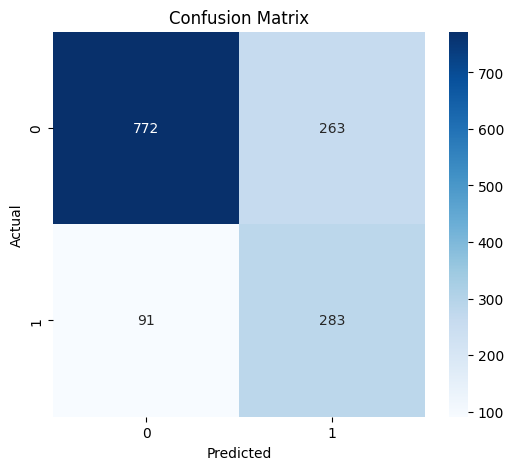

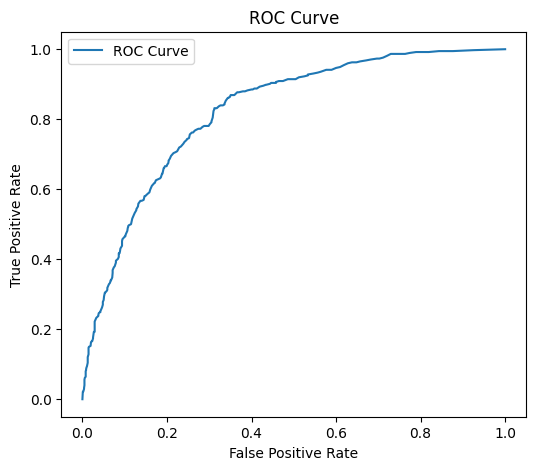

In [41]:
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Train a Random Forest model with class weighting
model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Tune threshold for better recall
optimal_threshold = 0.4  # Lowering the threshold increases recall
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Interpretation:**
1.   The **confusion matrix** reveals the model's performance in classifying churn, showing it's better at predicting non-churn (548 true negatives) but struggles with accurately identifying churn (335 true positives, but also 487 false positives and 39 false negatives).  This translates to a high precision (93%) for non-churn but low recall (53%), while for churn, it's the opposite, with low precision (41%) but high recall (90%).
2.   The **ROC curve** visually confirms the model's overall performance is better than random chance, though the shape suggests room for improvement.  The classification report summarizes these findings, highlighting the trade-off between precision and recall, likely influenced by the class imbalance in the data, and resulting in an overall accuracy of 63%.  Essentially, the model tends to over-predict churn, catching most actual churn cases but also incorrectly flagging many non-churning customers.



**Section 4: Model Interpretation and Explainability**

To interpret and explain the model interpretation techniques like **Local Interpretation using LIME**, **Permutation Importance**, **Partial Dependence Plots** and **Individual Conditional Expectation** are used.

**4.1 Local Interpretation using LIME**

LIME (Local Interpretable Model-agnostic Explanations) is applied to explain individual predictions. The top features influencing the prediction for selected customer instances are displayed. Visual explanations are also provided through plots.

**LIME Explanation Process:**
1.   **LIME Initialization:**
The **LimeTabularExplainer** is initialized with the training data (**X_train**), feature names, and target class names (**Not Churn** and **Churn**). This explainer is set up for classification tasks, allowing us to interpret the predictions made by our model.
2.   **Test Instance Selection:**
Several customer instances (specified by their indices) are selected from the test set **(X_test**). For each instance, LIME explains the individual prediction made by the model.
3.   **Model Prediction & Probability:**
For each selected instance, the **Random Forest model** predicts the probability of churn and non-churn. These probabilities are printed, showing the likelihood of the customer churning or not.
4.   **Top Influencing Features:**
LIME identifies the top features that influenced the model's decision for each instance. These features are printed with their respective impact scores, indicating how much each feature contributed to the prediction.
5.   **Visualization:**
A visualization of the explanation is generated using LIME's built-in **as_pyplot_figure()** function. This graph helps to visually understand which features had the most influence on the model’s prediction for that specific instance.
6.   **Saving the Visualization:**
Each explanation plot is saved as a PNG file (**lime_explanation_{index}.png**) with high resolution, allowing for easy storage and sharing of the visualized explanations.



In [48]:
!pip install lime
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

# Choose multiple test instances to analyze
sample_indices = [5, 10, 15]  # Change indices to analyze different customers

for index in sample_indices:
    instance = X_test.iloc[index].values.reshape(1, -1)

    # Explain instance with LIME
    exp = explainer.explain_instance(instance.flatten(), models["Random Forest"].predict_proba)

    # Print predicted probabilities
    proba = models["Random Forest"].predict_proba(instance)[0]
    print(f"\n🔹 **Customer Index {index}**")
    print(f"   - Churn Probability: {proba[1]:.2f}")
    print(f"   - Not Churn Probability: {proba[0]:.2f}")

    # Get Top Influential Features
    top_features = exp.as_list()
    print("   - **Top Factors Influencing Prediction:**")
    for feature, impact in top_features[:5]:  # Show only top 5 features
        print(f"     ➤ {feature} | Impact: {impact:.4f}")

    # Enhanced Visualization
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Customer Index {index}", fontsize=14)

    # Save plot
    plt.savefig(f"lime_explanation_{index}.png", dpi=300, bbox_inches='tight')
    plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

**Interpretation:** These LIME explanations reveal the key factors influencing churn predictions for three individual customers.  For customers 5 and 10, the absence of a two-year contract and the presence of fiber optic internet service are the strongest drivers pushing the prediction towards churn, while longer tenure and higher total charges slightly reduce that probability.  Customer 15, however, has a much lower churn probability, primarily due to the presence of a two-year contract, despite also having fiber optic internet.  Essentially, contract type and internet service are strong churn predictors, with two-year contracts significantly reducing the likelihood of churn, while fiber optic internet increases it. Tenure and total charges play a secondary role, with longer tenure and higher charges associated with lower churn probability.

**4.2 Permutation Feature Importance**

This method is used to compute feature importance based on the effect of permuting features on model performance. The features are ranked by importance, and a bar chart is generated to visualize their significance.

**Key Steps:**
*  **Model Selection:** The **Random Forest** model is selected as the best-performing model from a previously trained set of models.
*  **Train-Test Split:** The dataset is split into training and testing sets using **train_test_split**. The split is set to 80% for training and 20% for testing, with a fixed random seed for reproducibility.
*   **Permutation Importance:** **Permutation Importance** is used to compute feature importance by evaluating the change in model performance (accuracy) when the values of each feature are randomly shuffled. This method provides an insight into the impact of each feature on the model's prediction.
The permutation importance is computed for the **Random Forest** model on the test set, with the number of repeats set to 10 for robustness.
*   **Sorting and Plotting:**The features are sorted based on their importance scores, and a horizontal bar chart is plotted using **matplotlib**. The plot shows the importance of each feature in predicting the target variable, where higher bars represent more important features.
*   **Visualization:** The plot is displayed with labeled axes and a title, making it easy to interpret the relative importance of features in the **Random Forest** model.

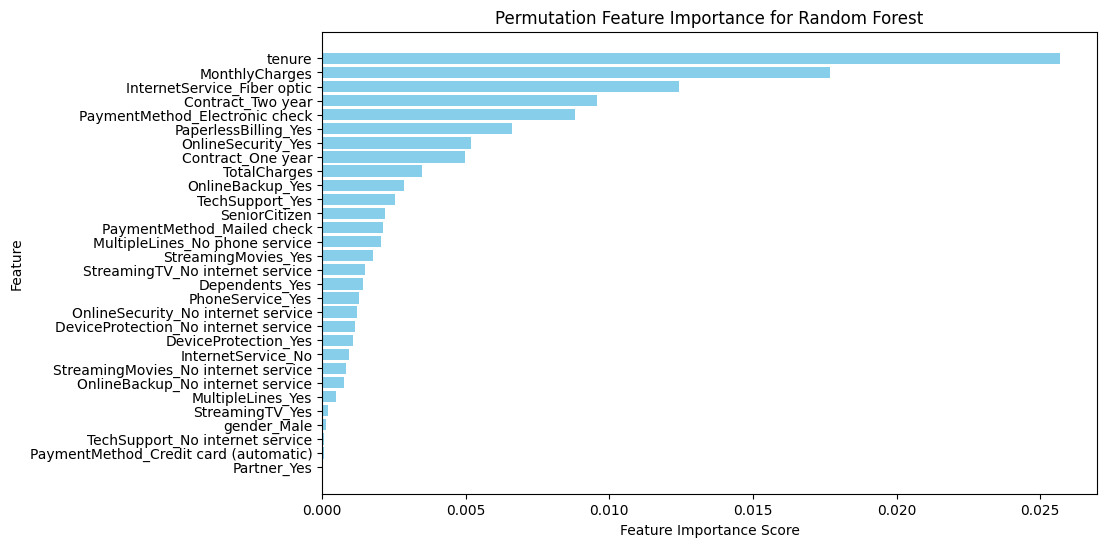

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

best_model = models["best_model"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute feature importance using permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()

# Extract model name for title
model_name = "Random Forest" # Hardcoded since only Random Forest used in Gridsearch.

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance for " + model_name)
plt.show()

**Interpretation:** This horizontal bar chart displays the permutation feature importance for a Random Forest model, revealing which features have the greatest impact on the model's predictions.  The length of each bar represents the feature's importance score, with longer bars indicating higher importance.  "tenure" stands out as the most influential feature, followed by "MonthlyCharges," "InternetService_Fiber optic," and "Contract_Two year," suggesting these factors play a crucial role in predicting the target variable.  Conversely, features like "Partner_Yes" and "PaymentMethod_Credit card (automatic)" have the lowest importance scores, indicating a minimal impact on the model's predictions.  Overall, the chart provides insight into the relative importance of each feature in the Random Forest model, enabling feature selection or further analysis to focus on the most influential variables.


**4.3 Feature Importance Analysis**

**Key Steps:**
*  **Feature Importance Calculation:** A DataFrame is created to store the importance of each feature based on permutation importance. This helps in understanding which features have the most influence on the model's predictions.
*   **Sorting Features by Importance:** The features are sorted in descending order of their importance values to highlight the most significant predictors.
*   **Interpretation**: The printed DataFrame provides insights into the contribution of each feature, allowing for potential feature selection or engineering improvements.

In [34]:
 # Create DataFrame with feature importance values
feature_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)


                                  Feature  Importance
1                                  tenure    0.065933
10            InternetService_Fiber optic    0.049752
3                            TotalCharges    0.047126
2                          MonthlyCharges    0.045848
28         PaymentMethod_Electronic check    0.038396
13                     OnlineSecurity_Yes    0.026615
25                      Contract_Two year    0.025621
19                        TechSupport_Yes    0.021221
26                   PaperlessBilling_Yes    0.019021
5                             Partner_Yes    0.015543
24                      Contract_One year    0.013272
15                       OnlineBackup_Yes    0.012136
4                             gender_Male    0.011568
9                       MultipleLines_Yes    0.010717
0                           SeniorCitizen    0.010149
6                          Dependents_Yes    0.009794
27  PaymentMethod_Credit card (automatic)    0.007026
21                        St

**Interpretation:** The table above ranks the importance of different customer characteristics in predicting something (like churn, for example).  Tenure (how long someone has been a customer) is the most important factor, followed by monthly charges, having fiber optic internet, and having a two-year contract.  Other factors like payment method and online security also play a role, while things like having a partner or certain streaming services have very little impact on the prediction.  Basically, the chart shows which customer traits are most useful for making predictions.


**4.4 Partial Dependence Plots (PDP)**

Partial Dependence Plots are used to visualize how specific features influence the model’s predictions. In this case, PDPs are generated for tenure, MonthlyCharges, and TotalCharges to analyze their individual impact.

**Key Steps:**
* **Best Model Selection:** The trained **Random Forest** model (best_model) is used to compute the partial dependence of the selected features, helping us to understand how each feature contributes to the predicted outcome.
* **Visualization:** The **PartialDependenceDisplay.from_estimator()** function is used to generate PDPs with a grid resolution of 50. The plots interpret the relationships between input features and predicted probabilites.

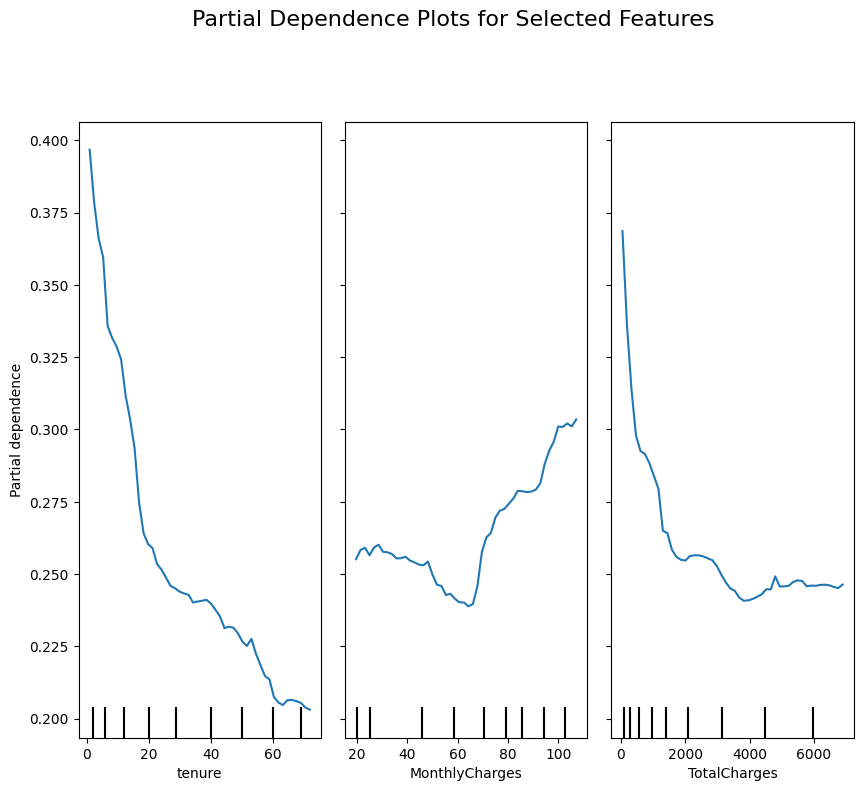

In [105]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Train the model (Random Forest in this case)
best_model.fit(X_train, y_train)

# Plot Partial Dependence for specific features
features = ['tenure', 'MonthlyCharges', 'TotalCharges']  # Example features for PDP

# Create a figure and a set of subplots with adjusted layout
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

# Use PartialDependenceDisplay to plot the PDPs
PartialDependenceDisplay.from_estimator(best_model, X_train, features=features, ax=ax, grid_resolution=50)

# Add a super title to the figure (instead of individual subplot titles)
fig.suptitle('Partial Dependence Plots for Selected Features', fontsize=16, y=1.02)  # Adjust y for vertical positioning

# Adjust subplot spacing (optional, if needed)
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing between subplots to make it at the center

# Display the plot
plt.show()

**Interpretation:** The above figure presents partial dependence plots for three features (tenure, MonthlyCharges, and TotalCharges) from a machine learning model, illustrating the marginal effect each feature has on the model's predictions while holding other features constant.  The plots reveal the relationship between each feature and the prediction target, showing how the model's output changes across the range of each feature. For instance, the tenure plot suggests a general decrease in partial dependence as tenure increases, while MonthlyCharges and TotalCharges show more complex, non-linear relationships with the target variable. These plots help in understanding the individual contribution of each feature to the model's predictions and can aid in feature selection or engineering.

**4.5 Individual Conditional Expectation (ICE)**

ICE plots show how individual predictions change as a feature varies, offering insights into the model's decision-making process for specific instances. These plots help interpret the model’s behavior by illustrating feature influence on predictions.

**Key Steps:**
* **Grid Resolution:** The feature space is divided into 50 grid points to capture smooth changes in prediction behavior.
* **Insights**: This visualization aids in understanding which features impact predictions the most, providing valuable insights for business decision-making.



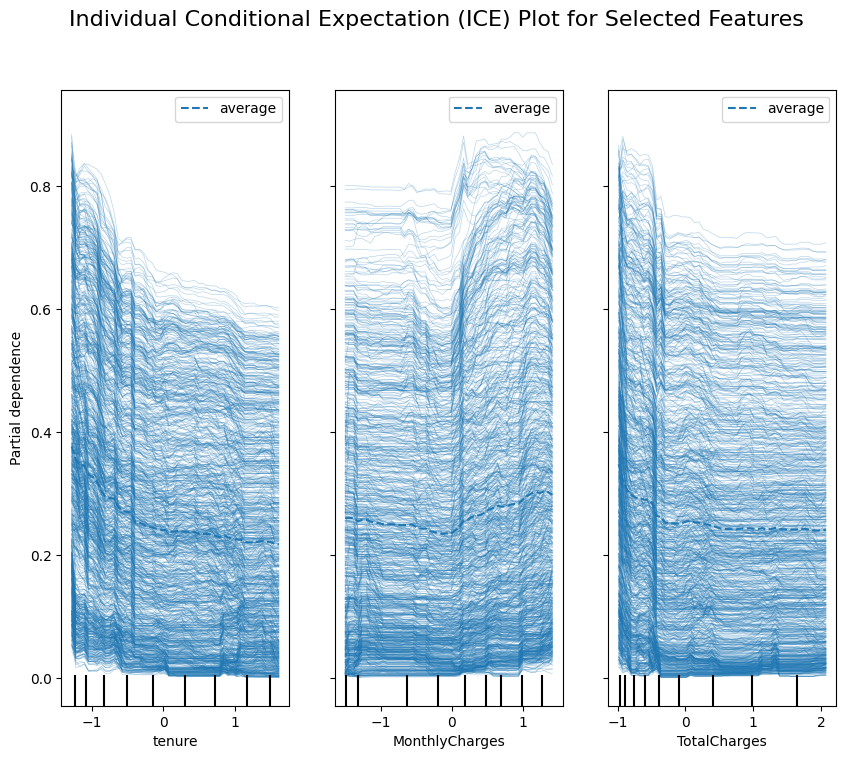

In [47]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Train the model (Random Forest in this case)
best_model.fit(X_train, y_train)

# Plot ICE for specific features
features = ['tenure', 'MonthlyCharges', 'TotalCharges']  # Example features for ICE
fig, ax = plt.subplots(figsize=(10, 8))

# Use PartialDependenceDisplay to plot ICE and PDPs together
PartialDependenceDisplay.from_estimator(best_model, X_train, features=features,
                                         kind='both', ax=ax, grid_resolution=50)

# Center the title using suptitle
fig.suptitle('Individual Conditional Expectation (ICE) Plot for Selected Features', fontsize=16, ha='center')

# Display the plot
plt.show()


**Interpretation:** The figure displays Individual Conditional Expectation (ICE) plots alongside partial dependence plots (PDPs) for three features—tenure, MonthlyCharges, and TotalCharges—from a trained model, likely a Random Forest. The ICE plots show how the model's predictions for individual instances change as each feature varies, revealing potential heterogeneous relationships. The overlaid PDPs represent the average prediction across all instances for each feature value, summarizing the overall trend.  By visualizing both ICE and PDP, we can observe the average relationship while also noting any individual variations in how the features influence predictions. For instance, while the PDP for tenure might show a general decrease in prediction as tenure increases, the ICE curves could reveal specific customer segments where this trend differs.

**Section 5: Model Saving**

The **joblib.dump()** function is used to save the objects to disk. This includes **the** scaler object, which is saved as **"scaler.pkl"**.
The label_encoder object, which is saved as **"label_encoder"**.pkl. The scaler file stores the mean and standard deviation of each feature (from training data) for scaling, while the label encoder file stores the mapping between original and numerical labels for the target variable.
Finally, the **'telco_churn_model'**
 is saved for future use. The model is saved as a .pkl file using joblib, allowing it to be loaded and used for predictions without retraining.

In [71]:
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Save the scalar, label encoder and trained model to a file
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(model, 'telco_churn_model.pkl')

print("Scaler and label encoder saved successfully! and Model saved as 'telco_churn_model.pkl'")

Scaler and label encoder saved successfully! and Model saved as 'telco_churn_model.pkl'
